## Testing Functions 
  - [Testing Divide Image](#ch1)
  - [Testing DCT](#ch2)  
  - [Testing Run length](#ch3)
  - [Testing Zigzag runner](#ch4)
  - [Quantizer](#ch5)

## jpeg full pipeline & compression ratio 
  - [here](#ch6)

In [4]:
import cv2 
import matplotlib.pyplot as plt 
import numpy as np

In [5]:
img = cv2.imread("me.png",cv2.IMREAD_GRAYSCALE)

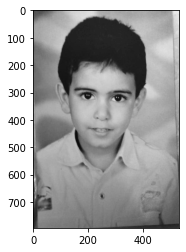

In [6]:
plt.imshow(img,'gray')

### Testing Divide Image <a><a name="ch1">

In [18]:
from Divide import Divide

In [ ]:
divider= Divide(n= 64)

In [ ]:
img_samples= divider.encoder(img)
# now we should have dictinaory that have
# keys are tuples and values represents 64*64 samples
print(f"shape of orignal image is {img.shape}")
print(f"number of key,value pair in our output {len(img_samples)}")

shape of orignal image is (795, 533)
number of key,value pair in our output 117


This good as if we have


```
ciel(795/64) = 13 
ciel(533/64) = 9
```


Hence we have right formulation
now let's test a sample by plotting it

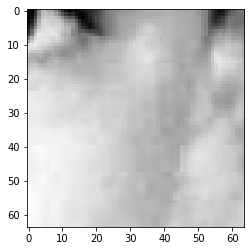

In [ ]:
plt.imshow(img_samples[(5,5)],"gray")

now lets try to reconstruct the iamge back 

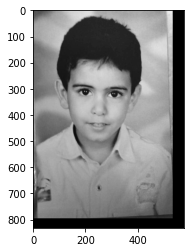

In [ ]:
img_reconstructed= divider.decoder(img_samples,13,9)
plt.imshow(img_reconstructed,"gray")

The black here is the padding effect

### Testing DCT <a><a name="ch2">

In [19]:
from dct import DCT 

now I will re-ddivide the image above to 8*8 samples to cope with the standard JPEG

In [20]:
divider = Divide(8)
img_samples= divider.encoder(img)
len(img_samples)

6700

In [21]:
transformer = DCT(8)

our dct blocks intitalize the filters that should exist for every u and v 
in a contigious list named weights. Although weights is an 1D list its meant to be 2D but with having a row-major indexing for matrices  


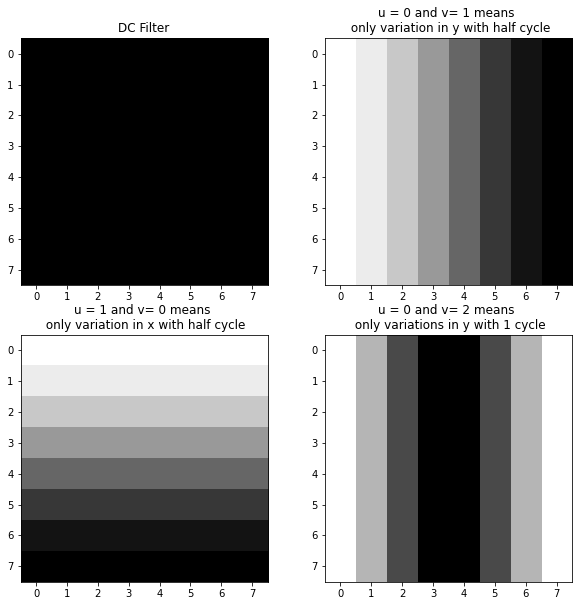

In [10]:

plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.imshow(transformer.weights[0],"gray")
plt.title("DC Filter");
plt.subplot(2,2,2)
plt.imshow(transformer.weights[1],"gray")
plt.title("u = 0 and v= 1 means \n only variation in y with half cycle");
plt.subplot(2,2,3)
plt.imshow(transformer.weights[8*1],"gray")
plt.title("u = 1 and v= 0 means \n only variation in x with half cycle");

plt.subplot(2,2,4)
plt.imshow(transformer.weights[2],"gray")
plt.title("u = 0 and v= 2 means \n only variations in y with 1 cycle");


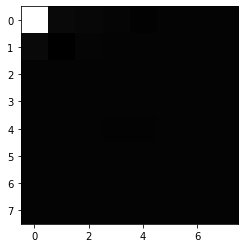

In [11]:
encoding_sample = transformer.encode(img_samples[(80,60)])
plt.imshow(encoding_sample,"gray")

comparing the DCT results with the function in scipy by using the code brought from here

comparing the results of our dct encoder to the one preovided in lab

In [1]:
def Block8_DCT(block_8): 
  n = 8 
  basis=np.zeros((n,n))

  #looping over the size of the basis and size of the input
  dct_result=np.zeros((n,n))
  for u in range(n):
      for v in range(n):
          for x in range(n):
              for y in range(n):
                  # constructing the basis function
                  basis[x,y]=(np.cos((1/16)*(2*x+1)*u*np.pi))*(np.cos((1/16)*(2*y+1)*v*np.pi))
              
          
          # multiplying each pixel to the corresponding basis block and averaging them then storing in dct_result
          dct_result[u,v]=np.sum(block_8*basis)
  # Now Scaling
  dct_result[0,:]/=2;             #The first value in the block /64
  dct_result[:,0]/=2         #The first row /32
  dct_result/=16             #The first column /32
  return dct_result
    

In [2]:
def Block8_IDCT(block_8):
  n=8
  basis=np.zeros((n,n))
  idct_result=np.zeros((8,8))
  for u in range(n):
      for v in range(n):
          for x in range(n):
              for y in range(n):
                  basis[x,y]=(np.cos((1/16)*(2*x+1)*u*np.pi))*(np.cos((1/16)*(2*y+1)*v*np.pi));
              
          
          # multiplying each value of encoded_block to the corresponding
          # basis block and summing the result and storing it in the result_Idct block
          idct_result=idct_result+block_8[u,v]*basis;
  return idct_result

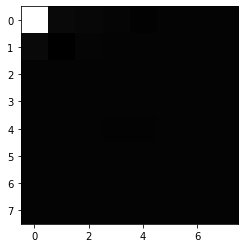

In [12]:
encoding_sample2 =Block8_DCT(img_samples[(80,60)])
plt.imshow(encoding_sample,"gray")

In [13]:
(encoding_sample2 == encoding_sample).all()

True

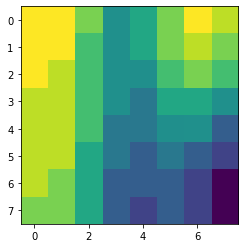

In [14]:
plt.imshow(Block8_IDCT(encoding_sample2))

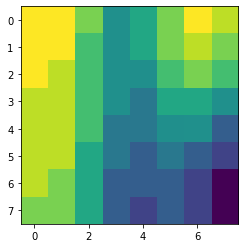

In [15]:
plt.imshow(transformer.decode(encoding_sample2))

end of triAL


now let's encode all the samples then try to decoe them to make sure the decoder works fine 

In [25]:
encodedsamples= []
reoderer = Zigzager(8)
quantizer= Quantizer()
for i in range(100): 
  for j in range(67): 
    t= (i,j)
    #X1= Block8_DCT(img_samples[t])
    #X2= transformer.encode(img_samples[t])
    encodedsamples.append(quantizer.encode(transformer.encode(img_samples[t])))


# now let's decodde them and reconstruct them  
decoded = {}
for i in range(100): 
  for j in range(67): 
    t= (i,j)
    #decoded[t]=Block8_IDCT(encodedsamples[i*67+j])
    decoded[t]=transformer.decode(quantizer.decoded(encodedsamples[i*67+j]))

Text(0.5, 1.0, 'Img after reconstructing from \n divier block and DCT')

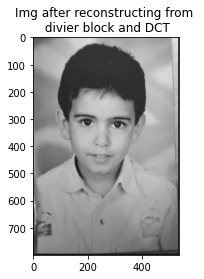

In [26]:
#from sklearn.preprocessing import MinMaxScaler
img_reconstructed= divider.decoder(decoded,100,67)
plt.imshow(img_reconstructed,"gray")
plt.title("Img after reconstructing from \n divier block and DCT")

we can note here the black on the sides is less from the image reconstructed in phase I. One might think that the DCT decoder may have made a balancing effect, But this happened  as a result of dividing the image into 8*8 originaly which would have samller pad if the image width and height are not divisable by 8. 

### Testing Run Length <a><a name="ch3">

In [8]:
from Run_Length import RunLength

In [9]:
compressor= RunLength()
x=[1,2,30,0,5,6,0,0,0,0,0,0,1,2,3,0,1,5]

In [10]:
y= compressor.encoder(x)
y

[1, 2, 30, 0, 1, 5, 6, 0, 6, 1, 2, 3, 0, 1, 1, 5]

we can see that this accomodadtes with the theory. Now let's ty to decode the same sequence and comapre it to the orignal array 

In [11]:
reconstructed =compressor.decoder(y)
print("Reconstructed array is ",reconstructed)
print("does all the value match ? : ", reconstructed==x)

Reconstructed array is  [1, 2, 30, 0, 5, 6, 0, 0, 0, 0, 0, 0, 1, 2, 3, 0, 1, 5]
does all the value match ? :  True


### Testing Zigzag <a><a name="ch4">

In [9]:
from zigzag import Zigzager

In [12]:
reoderer = Zigzager(3)
x= np.array([np.array([1,2,3]),np.array([4,5,6]),np.array([7,8,9])])

In [13]:
x_zigzag= reoderer.encoder(x)
x_zigzag

[1.0, 2.0, 4.0, 7.0, 5.0, 3.0, 6.0, 8.0, 9.0]

The above results is consistent with the theory. Now let's reocnstruct it back and chek the results. 

In [ ]:
x_recons = reoderer.decoder(x_zigzag)
print("reconstructed rray is ", x_recons)

reconstructed rray is  [array([1., 2., 3.]), array([4., 5., 6.]), array([7., 8., 9.])]


Which is equal to the orignal array. But we have converted the inner arraays to be of numpy dtype.

### Quantizer <a><a name="ch5">

In [12]:
from quantizer import Quantizer

## JPEG Pipeline <a><a name="ch6">

In [7]:
from jpeg_pipeline import JPEG 

In [8]:
pipeline = JPEG()

In [9]:
l = pipeline.compress(img)

In [10]:
l2= pipeline.decompress(l,100,67)

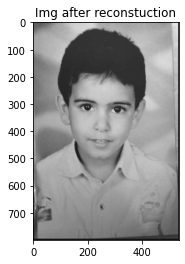

In [23]:
plt.imshow(l2,"gray");
plt.title("Img after reconstuction");

for using the higher compreesion ratio 
we set compressionn_Type = 1 

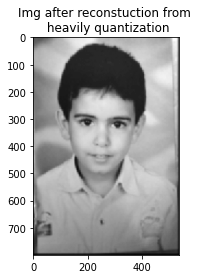

In [25]:
pipeline = JPEG(compression_Type= 1)
img_high = pipeline.compress(img)
dec_img= pipeline.decompress(l,100,67)
plt.imshow(dec_img,"gray");
plt.title("Img after reconstuction from \n heavily quantization");

Huffman 

In [12]:
from huffman_node import * 
from min_heap import * 

In [13]:
heap_= minHeap()
for c in l:
  heap_.push_(Huff_node(c,1))

heap_.normalize()
head = tree_builder(heap_) # build huffman's tree

In [14]:
encoder1 = Encoder()
encoded_list1 = encoder1.encode(head)

symbol: 49.0 , freq: 0.01058, encoding: 111111
symbol: 36.0 , freq: 0.00135, encoding: 111110111
symbol: 34.0 , freq: 0.00034, encoding: 11111011011
symbol: 80.0 , freq: 0.00017, encoding: 111110110101
symbol: 70.0 , freq: 0.00017, encoding: 111110110100
symbol: 147.0 , freq: 0.00068, encoding: 1111101100
symbol: 58.0 , freq: 0.00274, encoding: 11111010
symbol: 110.0 , freq: 0.00068, encoding: 1111100111
symbol: 108.0 , freq: 0.00068, encoding: 1111100110
symbol: 13 , freq: 0.00137, encoding: 111110010
symbol: 24.0 , freq: 0.00068, encoding: 1111100011
symbol: 119.0 , freq: 0.00069, encoding: 1111100010
symbol: 37.0 , freq: 0.00035, encoding: 11111000011
symbol: 69.0 , freq: 0.00017, encoding: 111110000101
symbol: 166.0 , freq: 0.00018, encoding: 111110000100
symbol: 152.0 , freq: 0.00070, encoding: 1111100000
symbol: 5.0 , freq: 0.01136, encoding: 111101
symbol: 120.0 , freq: 0.00070, encoding: 1111001111
symbol: 139.0 , freq: 0.00071, encoding: 1111001110
symbol: 124.0 , freq: 0.0007

In [15]:
encoder= dict(encoded_list1)
compressedimage="" 
for c in l: 
  compressedimage+=encoder[int(c)]
compressedimage

'001000110011101110010000100111000010100010010000110010110111111111000001110001001111011000011110010100111101101101101110100001000100100110100111010101000100101011001000100011001000100010010011100100111010011101100101000101100011000101100010110101011100000111000011100001110010110000001000100100010110000010111111111100011010111011001101101010000100000010111101000101111111101011011010011011001101101001111011000101100010110101100100010110101011010001010001110011100000010010000000100010010110001011011011010100010001101000110110000000000110010110010001001000101100000100100010110101011111001100011010100111000010000000100010001010111110001011110110011011100101011001000101110010000101111110010010011000111111011100100010010000011101101111010110010110110101000100111110001001000101101100010001010011101011010001101111001001000011011000110110110011110001011000100011000101110011101001111101110010110010000001011011000000101110100111110000011101101000000100101000010110010110110001101111110010001010100

while the non-compressed image 

In [16]:
heap2_= minHeap()
for c in np.reshape(img,(-1,)):
  heap2_.push_(Huff_node(c,1))

heap2_.normalize()
head2 = tree_builder(heap2_) # build huffman's tree

In [17]:
encoder_2 = Encoder()
encoded_list = encoder_2.encode(head2)

symbol: 155 , freq: 0.00566, encoding: 1111111
symbol: 85 , freq: 0.00567, encoding: 1111110
symbol: 147 , freq: 0.01138, encoding: 111110
symbol: 86 , freq: 0.00574, encoding: 1111011
symbol: 57 , freq: 0.00071, encoding: 1111010111
symbol: 46 , freq: 0.00072, encoding: 1111010110
symbol: 35 , freq: 0.00147, encoding: 111101010
symbol: 78 , freq: 0.00293, encoding: 11110100
symbol: 145 , freq: 0.01167, encoding: 111100
symbol: 144 , freq: 0.01175, encoding: 111011
symbol: 27 , freq: 0.01180, encoding: 111010
symbol: 124 , freq: 0.01192, encoding: 111001
symbol: 60 , freq: 0.00073, encoding: 1110001111
symbol: 58 , freq: 0.00075, encoding: 1110001110
symbol: 47 , freq: 0.00075, encoding: 1110001101
symbol: 44 , freq: 0.00077, encoding: 1110001100
symbol: 79 , freq: 0.00301, encoding: 11100010
symbol: 87 , freq: 0.00607, encoding: 1110000
symbol: 125 , freq: 0.01242, encoding: 110111
symbol: 143 , freq: 0.01256, encoding: 110110
symbol: 31 , freq: 0.00624, encoding: 1101011
symbol: 167 

In [18]:
encoder_= dict(encoded_list)
image="" 
for c in np.reshape(img,(-1,)): 
  image+=encoder_[int(c)]
image

'000000111010000001110111100011111010100101001001001010101001011010100101000100100100010010010001001001000100100100010010010001001001000100100100010010010001001001001001001000010010010010010010101010010100000010100111000111100000010100101010010100000010100001001001010101001011110001111111000111100100100100001001010000100100100010010010001001010101010011000100101000010010100001001010000100101000100100100001001001101010011101001100011001101011001000010011111010001111101001100101001100011001101011001101010001111001100111000011001111101001111010010101000101010000011001011110111111110001100100011001011110111111011101111010111101100010101010101010110010111010010100101110011000010010001000000011011001101000111110011110001111000111010010101001110100101010010100000010000101000000101000001100011101110010000000001000100100010000000110010101000100111011111011111011111011111011111011100011011100011100101100101100110110100110110111100111110000110000011000001100000110000011000100010000110000011000100

In [24]:
print(f"length of compressed {len(compressedimage)},vs the length of humman encoed non jpeg compressed img{len(image)}")
print(f"compression is {(np.size(img)*8)/len(compressedimage)*100}")


length of compressed 403024,vs the length of humman encoed non jpeg compressed img2926779
compression is 841.1111993330422
